In [1]:
# Fix for importing utils
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.dirname(os.path.dirname(SCRIPT_DIR)))
from analysis.utils import utils

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'.format})
font = {'family' : 'Ubuntu',
        'size'   : 22}

matplotlib.rc('font', **font)

# Visualization of ZPOS Data

Expects folder tree structure of

```
./
|- 02_Pozyx_Positioning_Data
|   |-KITCHEN
|   |-ZPOS
|
|- 03_Labels
    |-KITCHEN
    |-ZPOS
```
- Sitting was at around 10cm off of the ground. Standing was at around 1.6m


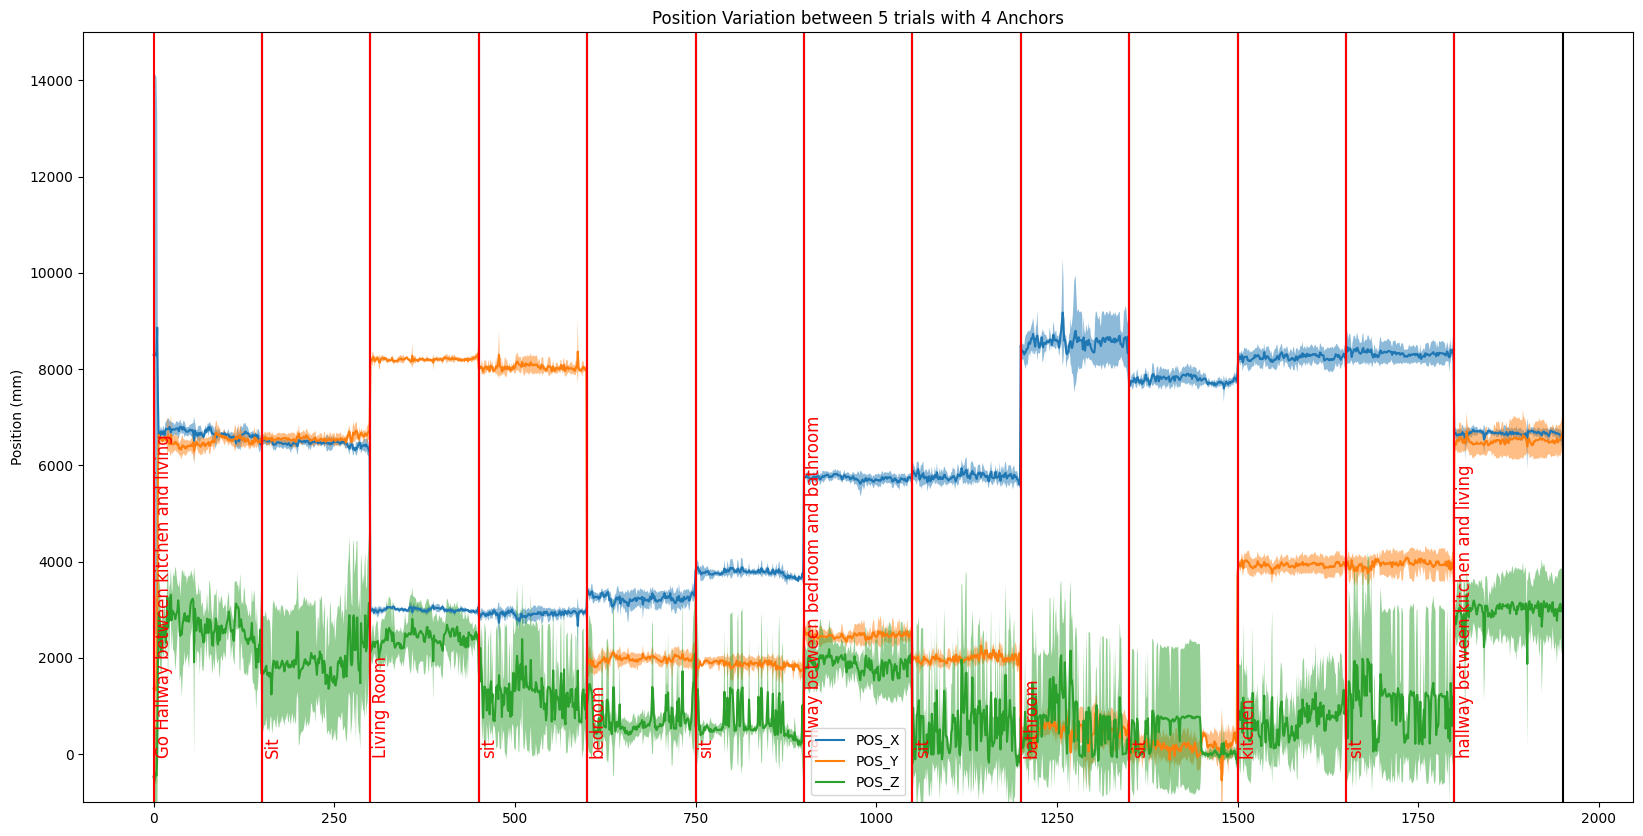

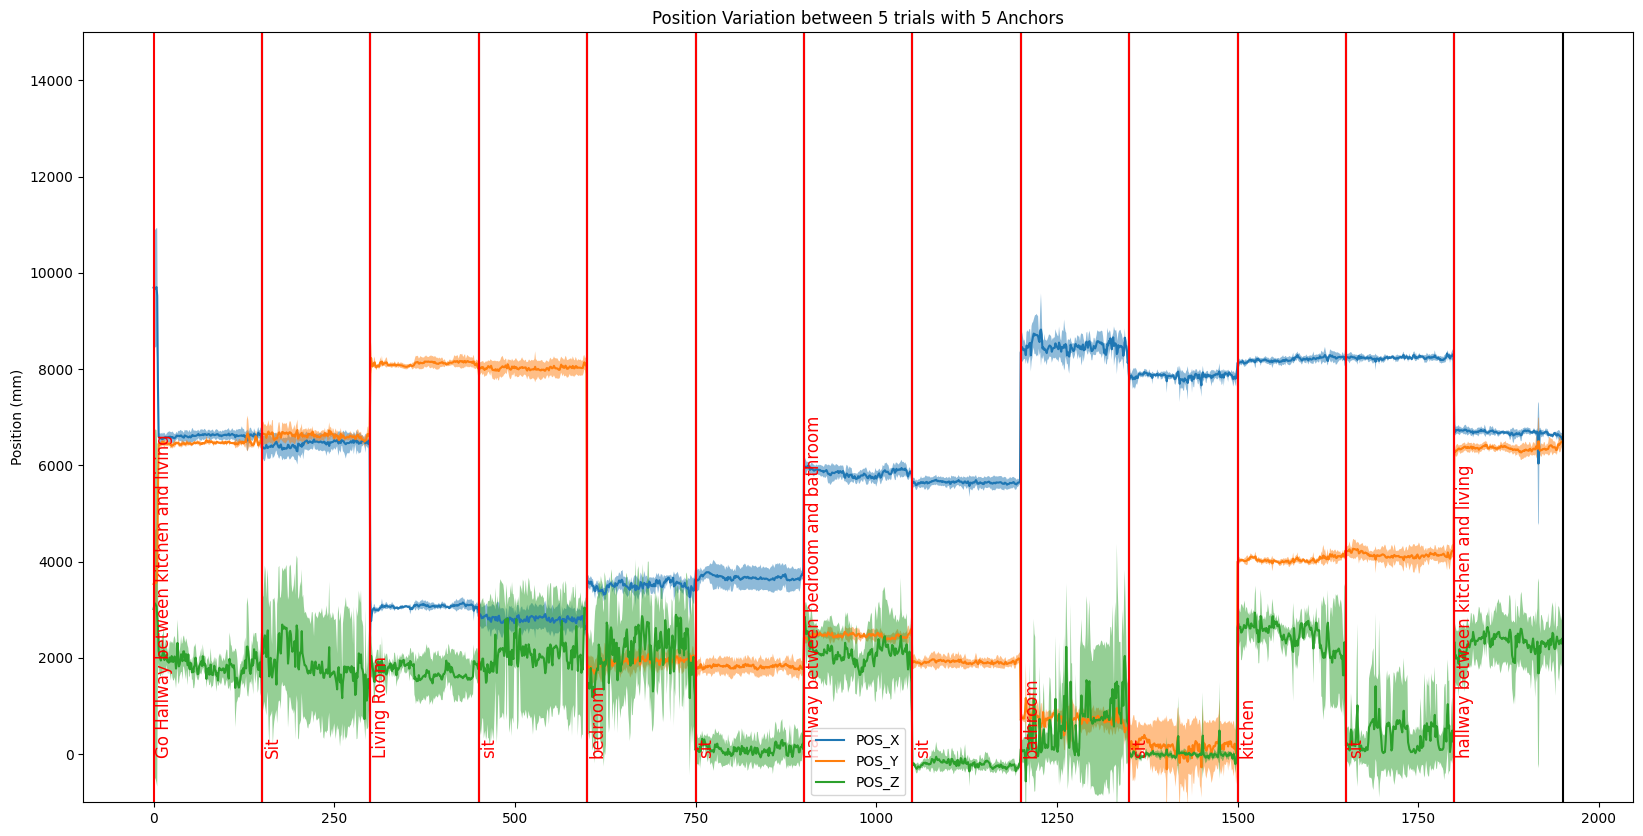

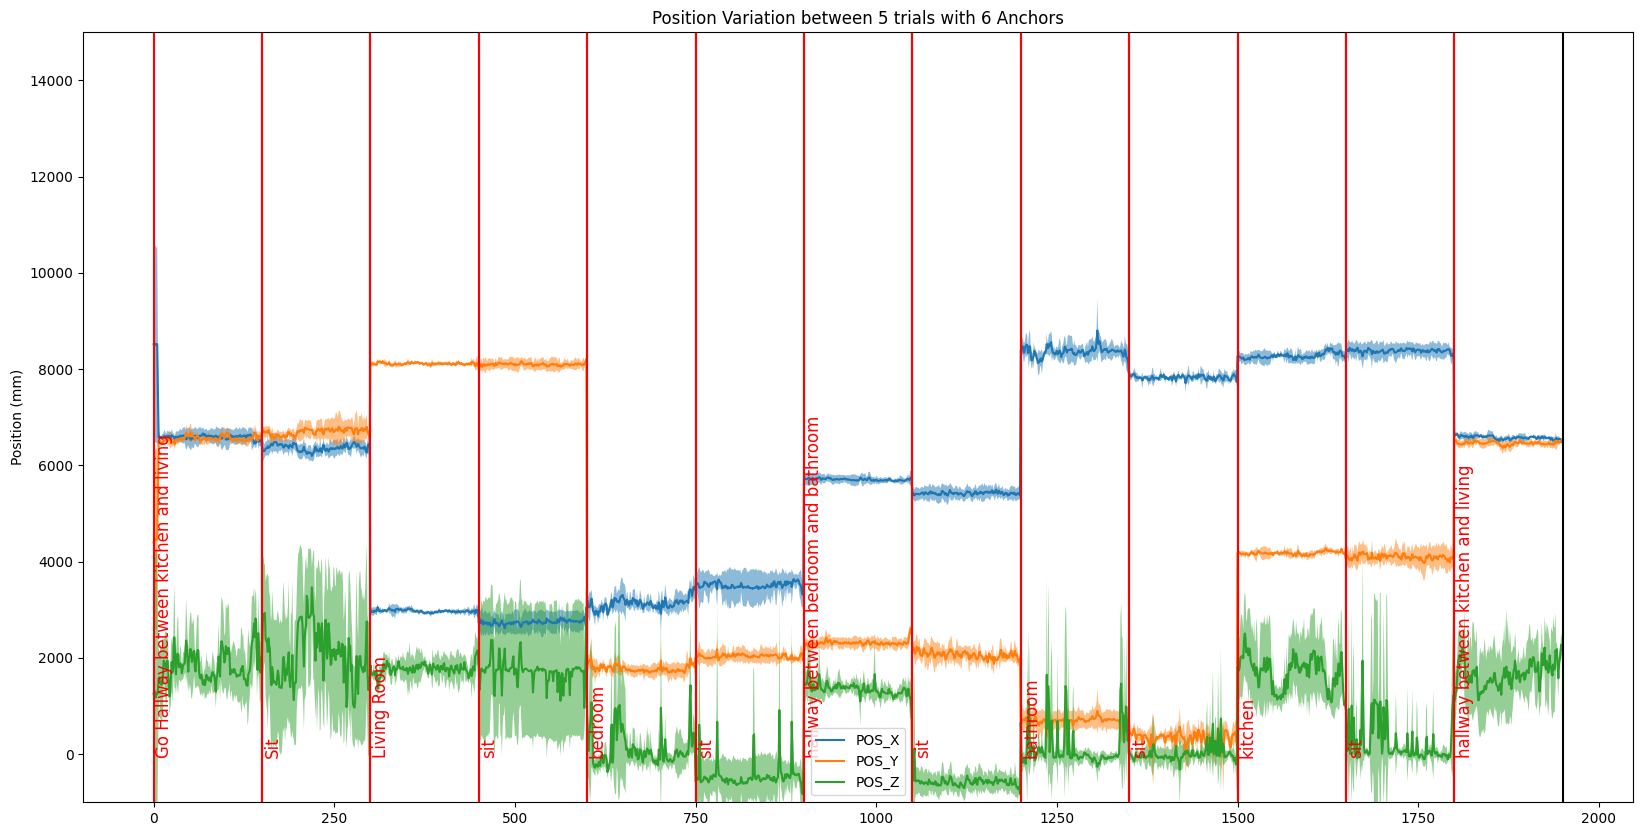

In [7]:
labels_dir = "03_Labels"
data_dir = "02_Pozyx_Positioning_Data"
NUM_POINTS = 150

%matplotlib inline
for anchor in range(4, 7):
    processed_trials = pd.DataFrame()
    for trial in range(4):
        TYPE = "ZPOS"
        ANCHORS = anchor
        TRIAL = trial+1

        label_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.txt"
        data_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.csv"

        label_fp = Path('.').joinpath(labels_dir, TYPE, label_fn)
        data_fp = Path('.').joinpath(data_dir, TYPE, data_fn)

        labels = utils.extract_time_labels(label_fp)

        data = pd.read_csv(data_fp)
        data.columns = ['Timestamp', 'POS_X', 'POS_Y', 'POS_Z', 'Heading', 'Pitch', 'Roll', 'ACC_X', 'ACC_Y', 'ACC_Z']
        data = data.set_index('Timestamp')

        # Segment the data into only the standing still portions.
        moving_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[1::2], labels[2::2])]
        moving_periods.append([float(labels[-1]['Timestamp']), float(labels[-1]['Timestamp'])+120])
        standing_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[0::2], labels[1::2])]

        ##################### CLEANING THE DATA ########################## 
        cleaned_data = (data
                        .pipe(utils.remove_periods, moving_periods)
                        .pipe(utils.interp1d_periods, standing_periods, num_points=NUM_POINTS)
                        .reset_index(drop=True)
                    )
        ##################################################################


        # To normalize in time, drop the index and fix the indexing (make start overlap with 10sec end)
        index = 0
        drop_index_labels = []
        for ind, _ in enumerate(labels[0::2]):
            drop_index_labels.append({'Timestamp': index, 'Label': labels[ind*2]['Label']})
            index += NUM_POINTS
            drop_index_labels.append({'Timestamp': index, 'Label': labels[ind*2+1]['Label']})


        # utils.plot_pozyx_data_with_timings(cleaned_data, ['POS_X', 'POS_Y', 'POS_Z'], drop_index_labels)
        # utils.plot_pozyx_data_with_timings(cleaned_data, ['Heading'], drop_index_labels, ylim=(0,360))
        processed_trials = pd.concat([processed_trials, cleaned_data], axis=0)

    # Means and Standard deviations for ensemble averages
    means = processed_trials.groupby(processed_trials.index).mean()
    stds = processed_trials.groupby(processed_trials.index).std()

    # Position
    ax = utils.plot_pozyx_data_with_timings(means, ['POS_X', 'POS_Y', 'POS_Z'], drop_index_labels)
    ax.fill_between(means.index, means['POS_X'] + stds['POS_X'], means['POS_X'] - stds['POS_X'], alpha=0.5)
    ax.fill_between(means.index, means['POS_Y'] + stds['POS_Y'], means['POS_Y'] - stds['POS_Y'], alpha=0.5)
    ax.fill_between(means.index, means['POS_Z'] + stds['POS_Z'], means['POS_Z'] - stds['POS_Z'], alpha=0.5)
    ax.set_title(f"Position Variation between 5 trials with {ANCHORS} Anchors")
    ax.set_xlabel("Index (Time normalized)")

    # # Heading
    # ax = utils.plot_pozyx_data_with_timings(means, ['Heading'], drop_index_labels, ylim=(0, 360))
    # ax.fill_between(means.index, means['Heading'] + stds['Heading'], means['Heading'] - stds['Heading'], alpha=0.5)
    # ax.set_title(f"Heading Variation between 5 trials with {ANCHORS} Anchors")